In [3]:
import pandas as pd
import numpy as np
import os
import GPy
import contextlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from SALib.sample import saltelli
from SALib.analyze import sobol

In [4]:
# Select file
n_runs = 2000

# Read Input Data
df_x = pd.read_csv(f'../ExploreModularCirc/Input/input_{n_runs}.csv')

# Select relevant inputs only
relevant_columns = []
for col in df_x.columns:
    relevant_columns.append(col)
    if col == 'T': break

# Select only varying inputs 
filtered_input = df_x[relevant_columns]

filtered_input

,# svn.c,pas.r,pas.c,pas.l,pat.r,pat.c,pat.l,pvn.r,pvn.c,ao.CQ,...,ti.CQ,rv.E_pas,rv.E_act,rv.v_ref,rv.k_pas,ra.E_pas,ra.E_act,ra.v_ref,ra.k_pas,T
0,27.687002,0.002863,0.155289,0.000045,0.306841,3.216036,0.001568,0.005335,14.078900,477.953026,...,524.214801,0.889745,2.067808,54.462362,0.013532,0.293514,0.265353,23.247156,0.027211,0.568772
1,19.583731,0.001892,0.216233,0.000076,0.970642,1.761023,0.002178,0.008813,21.074102,347.235884,...,256.323411,0.368834,0.647979,22.848745,0.027820,0.607115,0.225862,16.805634,0.015108,0.760948
2,11.151048,0.002357,0.116030,0.000035,0.960656,0.927419,0.001018,0.006478,29.982973,250.982182,...,437.947881,0.702951,1.336840,49.158198,0.022422,0.459658,0.165369,29.427299,0.022997,0.845690
3,23.578548,0.001390,0.232268,0.000054,0.552176,5.121283,0.002108,0.003369,17.822460,382.810481,...,380.042939,0.553660,2.745526,38.149745,0.016732,0.648015,0.314111,10.480856,0.014644,0.477865
4,21.266340,0.002222,0.184970,0.000062,0.677294,3.909687,0.001153,0.007160,26.330717,297.223537,...,491.995577,0.460890,3.375511,32.037828,0.017859,0.694387,0.155571,21.031370,0.028146,0.623831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,22.393565,0.001170,0.213831,0.000072,1.168851,1.813341,0.001275,0.008415,21.379235,175.766771,...,554.642705,0.908518,0.980711,46.635921,0.012539,0.549142,0.333573,19.293491,0.017104,0.428693
1996,25.006003,0.002440,0.268140,0.000070,1.010004,0.646608,0.002237,0.005103,12.550647,456.757314,...,267.395669,0.818438,0.892056,43.023698,0.011422,0.596489,0.136217,29.834239,0.020762,0.559338
1997,11.967946,0.001282,0.102683,0.000051,0.333453,4.840475,0.001626,0.007549,24.684456,326.037185,...,500.496064,0.606332,2.356785,34.676682,0.027117,0.285094,0.347216,10.267374,0.011634,0.752060
1998,18.796569,0.002965,0.183178,0.000060,0.513130,4.006461,0.001951,0.007089,26.025875,224.305035,...,393.872836,0.941761,3.034545,58.326374,0.022500,0.649355,0.294503,23.504578,0.029048,0.851294


In [5]:
# Load all sheets as a dictionary of DataFrames
sheets_dict = pd.read_excel(f"../ExploreModularCirc/Outputs/Output_2000/combined_all_outputdata_2000.xlsx", sheet_name=None)

# Access individual DataFrames by sheet name
y_PC1 = sheets_dict['y_PC1']
y_PC2 = sheets_dict['y_PC2']
y_PC3 = sheets_dict['y_PC3']

CO = sheets_dict['cardiac_output']
max_press = sheets_dict['max_pressure']
EF = sheets_dict['EF']

all_traces = sheets_dict['all_pressure_traces'].iloc[:, 0:100]


### Plot the pressure traces

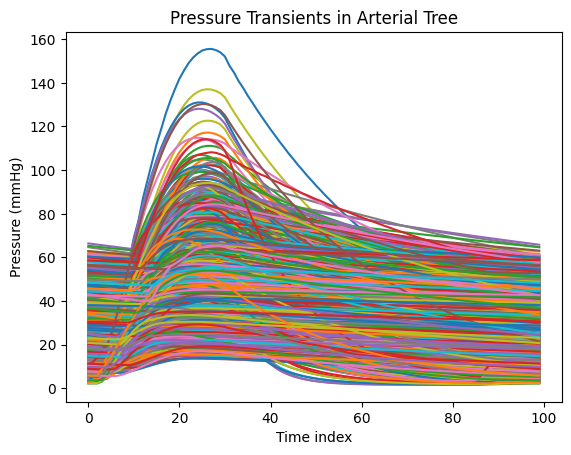

In [6]:
# Initialize the plot
fig, ax = plt.subplots()

# Loop over all realizations
for ind in range(len(all_traces)): 

    # Plot the interpolated pressure transient for each realization
    ax.plot(list(range(100)), all_traces.iloc[ind,:], label=f'Realisation {ind}')

# Set labels and title
ax.set_xlabel('Time index')
ax.set_ylabel('Pressure (mmHg)')
ax.set_title('Pressure Transients in Arterial Tree')

# Add legend to the plot
#ax.legend()

# Display the plot
plt.show()

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

pipeline = Pipeline([
                ('scl', StandardScaler()),
                ('pca', PCA(n_components=10)),
                ('post',   PowerTransformer())
            ])

signals_pca = pipeline.fit_transform(all_traces)

### Transform PCA data back to original space

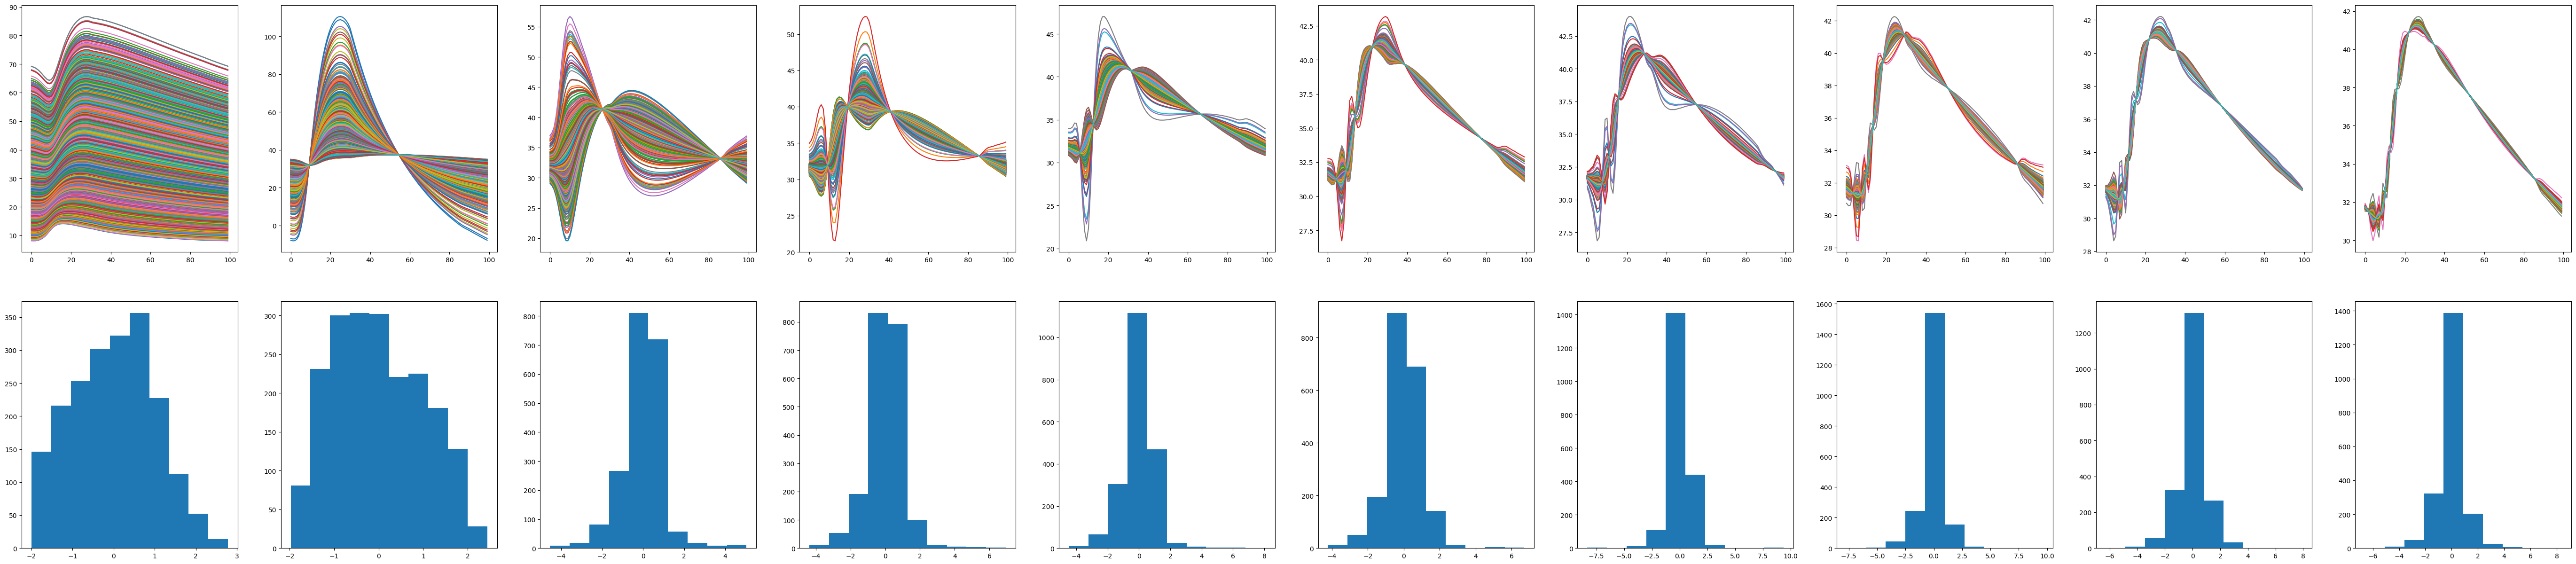

In [8]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(70, 15))

for i in range(signals_pca.shape[1]):
    temp = np.zeros(signals_pca.shape)
    temp[:, i] = signals_pca[:, i]
    
    signals_new = pipeline.inverse_transform(temp)
    
    ax[1][i].hist(signals_pca[:,i], bins=10)
    for signal in signals_new:
        ax[0][i].plot(signal)
        
plt.show()

### Linear Emulator

In [17]:
# Example input and output data
X = filtered_input
Y = y_PC1

emulator_name = 'PC1'

# Initialize the model
linear_model = LinearRegression()

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Predict the output for the test data
y_pred = linear_model.predict(X_test)

# Compute R² score for the predictions versus actual test data
r2 = r2_score(y_test.iloc[:,0], y_pred)
# Output R² score
print("R² score:", r2)

R² score: 0.9308227138805264


### Sensitivty Analysis

In [18]:
## SaLib user inteerface
from SALib import ProblemSpec 

# Define a `dict` defining the number of inputs, the names of the inputs, and the bounds on each input:
problem = ProblemSpec({
    'num_vars': len(relevant_columns),
    'names': relevant_columns,
    'bounds' : filtered_input[relevant_columns].describe().loc[['min', 'max']].T.values,
    "outputs" : ["PC1"],
})

# Samples inputs
problem.sample_sobol(1024)
X_samples = problem.samples


# Import emulator to np array
beta_matrix = np.array(linear_model.coef_)
intercept = np.array(linear_model.intercept_)

# Ensure intercept has the correct shape
intercept = intercept.reshape(-1) 

# Dynamically determine the shape of Y based on X and beta_matrix
num_samples = X_samples.shape[0]  # Number of rows in X
num_outputs = beta_matrix.shape[0]  # Number of columns in beta_matrix


# Sample outputs 
Y = np.zeros((X_samples.shape[0], num_outputs))  # Initialize Y with the right shape

# Compute Y
for i in range(num_samples):
    Y[i] = beta_matrix @ X_samples[i,:] + intercept
    
# Set output and run analysis
problem.set_results(Y)


(47104, 1)

In [19]:
linear_model.coef_.shape

(1, 22)

In [20]:
new = Y.reshape(-1)

 /opt/anaconda3/envs/ModularCirc/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning:unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


<Axes: >

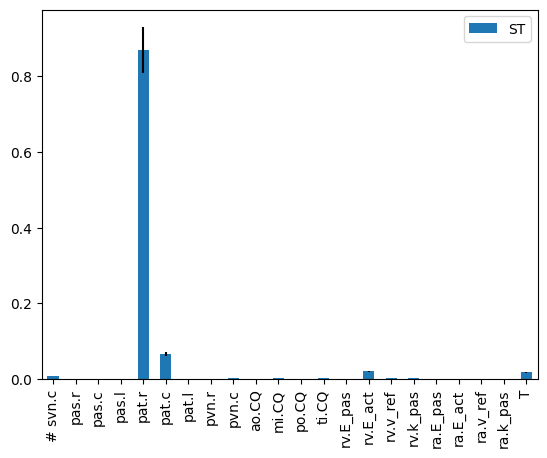

In [21]:
problem.set_results(new)
problem.analyze_sobol()

from SALib.plotting.bar import plot as barplot
Si = sobol.analyze(problem, new, print_to_console=False)
total, first, second = Si.to_df()
barplot(total)

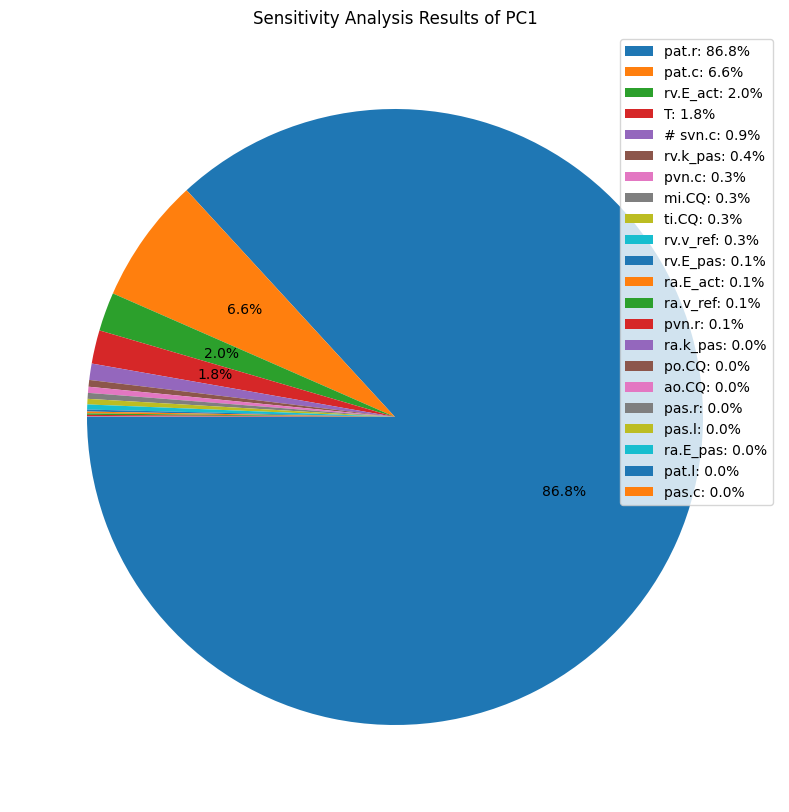

In [22]:
import matplotlib.pyplot as plt


# Sort the data in descending order of 'ST'
total.sort_values('ST', inplace=True, ascending=False)

# Assuming 'total' is a DataFrame with an index as labels and a column 'ST' for sizes
labels = total.index
sizes = total['ST']

# Create the pie chart
plt.figure(figsize=(15, 10))
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct=lambda pct: f'{pct:.1f}%' if pct >= 0.9 else '',  # Display percentages only if >= 1%
    startangle=180
)

# Add a title
plt.title(f'Sensitivity Analysis Results of {emulator_name}')

# Create a legend
# Include all labels in the legend regardless of their size
legend_labels = [f"{label}: {size / total['ST'].sum() * 100:.1f}%" for label, size in zip(labels, sizes)]
plt.legend(wedges, legend_labels, loc="best")

plt.show()

### Plot all sensitivities

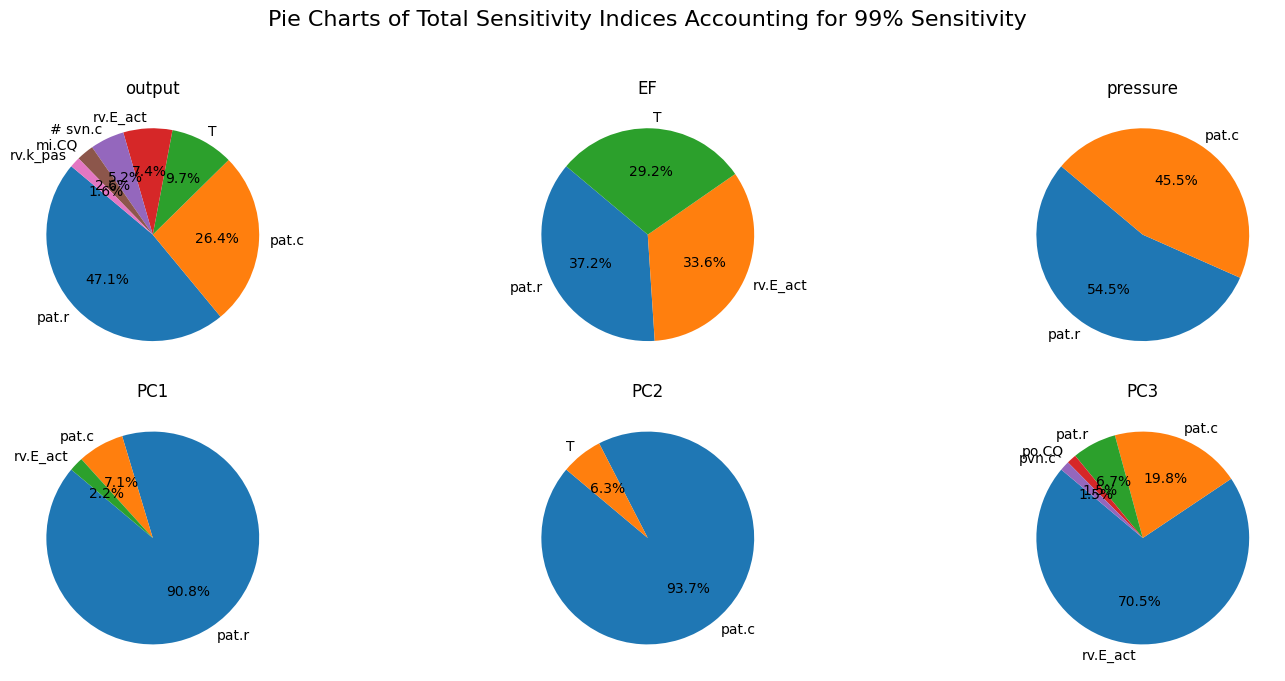

In [13]:

# Directory containing the CSV files
csv_directory = "../ExploreModularCirc/RH_sensitivity_results"

# Get list of CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.endswith(".csv")]

# Set up the overall plot
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle("Pie Charts of Total Sensitivity Indices Accounting for 99% Sensitivity", fontsize=16)

# Flatten the axes array to easily index subplots
axes = axes.flatten()

# Loop through the CSV files and plot pie charts
for i, file_name in enumerate(csv_files):
    # Read the CSV file
    file_path = os.path.join(csv_directory, file_name)
    df = pd.read_csv(file_path, index_col=0)
    
    # Extract data for the pie chart
    labels = df.index
    sizes = df["ST"]

    # Sort sizes and compute cumulative contribution
    sorted_indices = sizes.argsort()[::-1]
    sorted_sizes = sizes.iloc[sorted_indices]
    sorted_labels = labels[sorted_indices]

    cumulative_sum = sorted_sizes.cumsum()
    total_sum = sorted_sizes.sum()

    # Filter labels accounting for 95% of sensitivity
    significant_indices = cumulative_sum <= 0.96 * total_sum

    # Include the last element if necessary to reach the threshold
    #if not significant_indices.iloc[-1]:
    #    significant_indices.iloc[significant_indices.idxmax() + 1] = True

    filtered_sizes = sorted_sizes[significant_indices]
    filtered_labels = sorted_labels[significant_indices]

     # Extract title as the part after the last underscore in the filename
    title = file_name.rsplit("_", 1)[-1].replace(".csv", "")

    # Plot pie chart
    axes[i].pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(title)

# Remove unused subplots
for j in range(len(csv_files), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

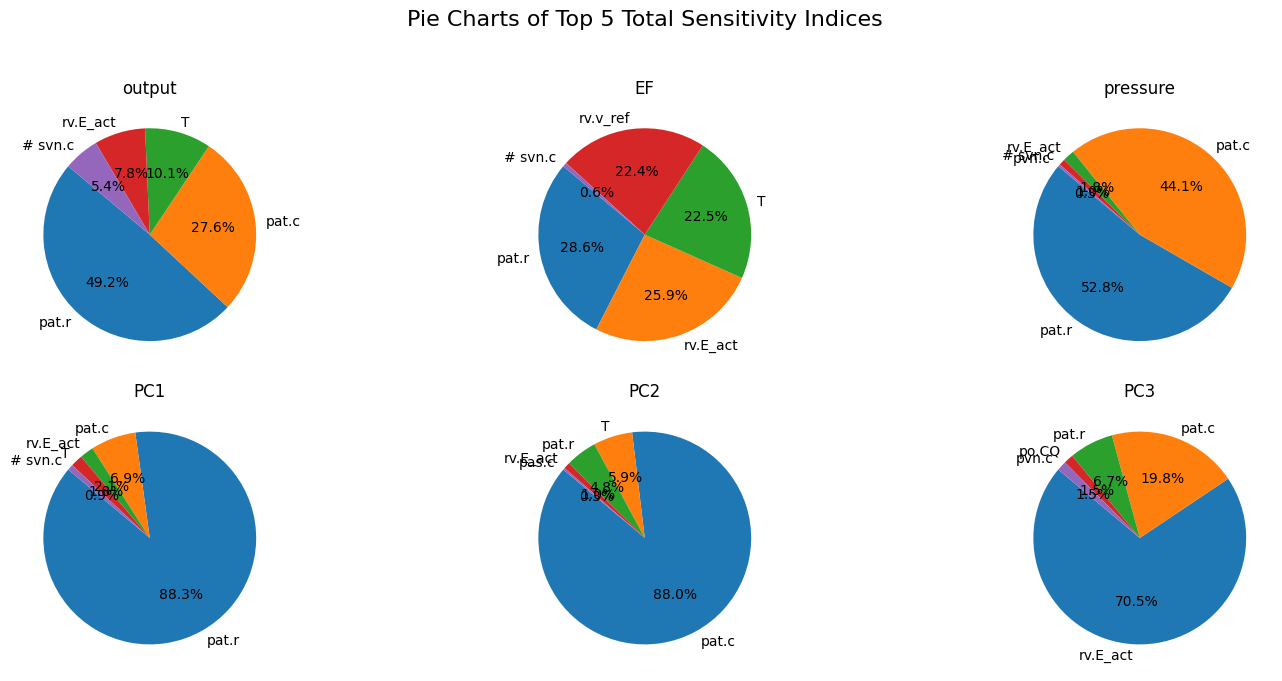

In [10]:

# Set up the overall plot
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle("Pie Charts of Top 5 Total Sensitivity Indices", fontsize=16)

# Flatten the axes array to easily index subplots
axes = axes.flatten()

# Loop through the CSV files and plot pie charts
for i, file_name in enumerate(csv_files):
    # Read the CSV file
    file_path = os.path.join(csv_directory, file_name)
    df = pd.read_csv(file_path, index_col=0)
    
    # Extract data for the pie chart
    labels = df.index
    sizes = df["ST"]

    # Sort sizes and select the top 5 most sensitive parameters
    sorted_indices = sizes.argsort()[::-1][:5]
    top_sizes = sizes.iloc[sorted_indices]
    top_labels = labels[sorted_indices]

    # Extract title as the part after the last underscore in the filename
    title = file_name.rsplit("_", 1)[-1].replace(".csv", "")

    # Plot pie chart
    axes[i].pie(top_sizes, labels=top_labels, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(title)

# Remove unused subplots
for j in range(len(csv_files), len(axes)):
    fig.delaxes(axes[j])

#axes[0].set_title("Cardiac Output")
#axes[2].set_title("Max Pressure")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
